# Imports and setting up viz

NB : conda lam1env (Python3.12)

In [228]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *
from tools_native import *
from tools_LIAISE import *
from tools_mesoNH import *

# sys.path.append('../../python_tools/aborella/PLOTS/')
# from datasets import *
sys.path.append('../../python_tools/aborella/UTIL/')
import xr_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [10., 8.]

# Load model files and edit datasets

In [230]:
mesoNH_dir = '../../../mesoNH_simulations'

In [231]:
def format_MesoNH_outputs_basic(filename, ds_name=None):
    ds = xr.open_mfdataset(filename)
    ds.attrs['name']= ds_name

    rename_dict={
        'time':'start_time',
        'longitude':'lon',
        'latitude':'lat'
    }
    ds = ds.rename(rename_dict)

    # Add time coordinate
    # Assuming 'time' coordinate is the starting time.
    base_time = pd.to_datetime(ds["start_time"].isel(start_time=0).item())
    print(f"Base time for the dataset: {base_time}")
    # Create a timedelta for each hour
    hourly_offsets = pd.to_timedelta(ds["record"].values, unit='h')
    new_time_vals = base_time + hourly_offsets
    # Assign new_time as a new coordinate, linked to the 'record' dimension
    ds = ds.assign_coords(time=("record", new_time_vals))
    ds = ds.swap_dims({"record": "time"})
    #drop start_time and record
    ds = ds.drop_vars(['start_time'])

    if 'LE_ISBA' in ds:
        ds = ds.rename({'LE_ISBA': 'flat'})
        ds['flat'].attrs['long_name'] = 'Latent Heat Flux on natural areas'
        ds['flat'].attrs['units'] = 'W m⁻²'
    if 'H_ISBA' in ds:
        ds = ds.rename({'H_ISBA': 'sens'})
        ds['sens'].attrs['long_name'] = 'Sensible Heat Flux on natural areas'
        ds['sens'].attrs['units'] = 'W m⁻²'
    if 'HU2M_ISBA' in ds:
        ds['rh2m'] = ds['HU2M_ISBA'] * 100.0 
        ds['rh2m'].attrs['long_name'] = 'Relative Humidity at 2m'
        ds['rh2m'].attrs['units'] = '%'
    if 'T2M_ISBA' in ds:
        ds = ds.rename({'T2M_ISBA': 't2m'})
        ds['t2m'].attrs['long_name'] = 'Temperature at 2m'
        ds['t2m'] = ds['t2m'] - 273.15
        ds['t2m'].attrs['units'] = '°C'
    if 'SWD' in ds:
        ds = ds.rename({'SWD': 'SWdnSFC'})
        ds['SWdnSFC'].attrs['long_name'] = 'Downward Shortwave Radiation at Surface'
        ds['SWdnSFC'].attrs['units'] = 'W m⁻²'

    return(ds)

In [232]:
filename='{}/LIAIS.1*.nc'.format(mesoNH_dir)
ds_orig = format_MesoNH_outputs_basic(filename)
ds_orig

Base time for the dataset: 2021-07-14 01:00:00


<xarray.Dataset> Size: 932MB
Dimensions:    (time: 408, nj: 164, ni: 290, start_time: 1)
Coordinates:
  * ni         (ni) float64 2kB 0.0 2e+03 4e+03 ... 5.74e+05 5.76e+05 5.78e+05
  * nj         (nj) float64 1kB 0.0 2e+03 4e+03 ... 3.22e+05 3.24e+05 3.26e+05
    lat        (nj, ni) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
    lon        (nj, ni) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
  * time       (time) datetime64[ns] 3kB 2021-07-14T01:00:00 ... 2021-07-31
Dimensions without coordinates: start_time
Data variables:
    HU2M_ISBA  (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    sens       (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    flat       (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    SWdnSFC    (time, start_time, nj, ni) float64 155MB dask.array<chunksize=(1, 1, 164, 290), meta=np.ndarray>
    t2m        (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    rh2m       (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
Attributes:
    MNH_cleanly_closed:  yes
    history:             Mon May 13 12:05:17 2024: ncecat -v HU2M_ISBA,time,l...
    NCO:                 netCDF Operators version 5.0.6 (Homepage = http://nc...
    name:                None

# Maps

/home/ptiengou/Documents/Data and Python scripts/netcdf-scripts/python_notebooks/LMDZOR/../../python_tools/tools.py:574: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(polygon[:, 0], polygon[:, 1], 'r-', linewidth=2, c='red')


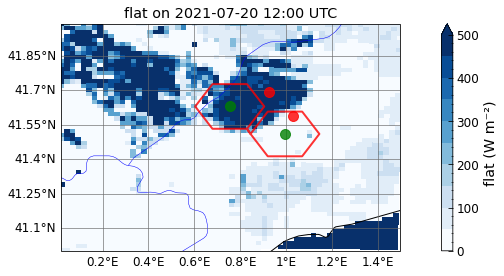

In [251]:
var='flat'
vmin=0
vmax=500
# vmin,vmax=None, None
cmap=blues
map_mesoNH_timestamp_restrict(ds_orig, 
                     var,
                     vmin=vmin, vmax=vmax, cmap=cmap,
                     timestamp='2021-07-20T12:00:00',
                     add_liaise=True,
                    lon_min=0., 
                    lon_max=1.5, 
                    lat_min=41, 
                    lat_max=42,
                    poly=both_cells
                     )

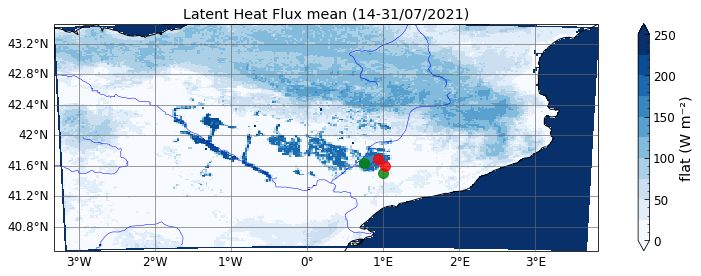

In [234]:
var='flat'
vmin=0
vmax=250
# vmin,vmax=None, None
cmap=blues
map_mesoNH_mean(ds_orig, 
                 var,
                 vmin=vmin, vmax=vmax, cmap=cmap,
                 title='Latent Heat Flux mean (14-31/07/2021)',
                 add_liaise=True
                 )

# Time series

/home/ptiengou/Documents/Data and Python scripts/netcdf-scripts/python_notebooks/LMDZOR/../../python_tools/tools.py:754: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


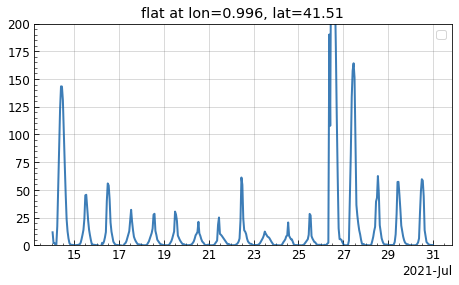

In [235]:
var='flat'
ds=ds_orig
vmin=0
vmax=200
time_series_lonlat_mesoNH(ds, var, 
                          lon=ElsPlans_lon, 
                          lat=ElsPlans_lat,
                          vmin=vmin, vmax=vmax
                          )

# Subdataset for ICOLMDZ grid cells

In [236]:
ds_elsplans= subset_dataset_by_polygon(ds_orig, elsplans_cell)
ds_cendrosa= subset_dataset_by_polygon(ds_orig, cendrosa_cell)

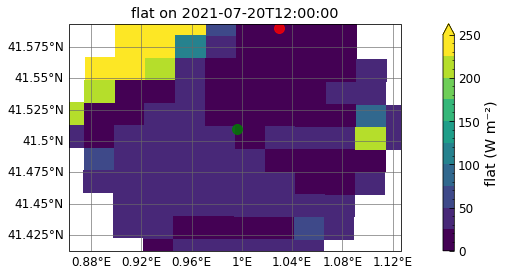

In [237]:
map_mesoNH_timestamp(ds_elsplans,
                 var='flat',
                 vmin=0, vmax=250, cmap=myvir,
                #  title='Latent Heat Flux mean (14-31/07/2021) in Ebro basin',
                 add_liaise=True,
                 timestamp='2021-07-20T12:00:00',
                 )

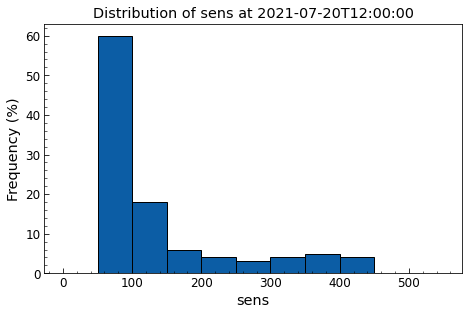

In [256]:
ds=ds_cendrosa
# ds=ds_elsplans
timestamp='2021-07-20T12:00:00'
var='sens'
xmin=0
xmax=550
nbins=11
bins_timestamp(ds, var, timestamp, nbins=nbins, xmin=xmin, xmax=xmax)

# Compare with LMDZ

In [239]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe

def reformat_datasets_for_comparison(ds_source_initial, ds_target_rectilinear, var_names):
    """
    Reformats two datasets for comparison:
    1. Converts the source dataset (with record, nj, ni dimensions) to have a 'time' dimension
       based on record index, and regrids it onto the target dataset's rectilinear grid.
    2. Aligns the time dimension of both datasets.

    Args:
        ds_source_initial (xr.Dataset): The source dataset with LE_ISBA(record, nj, ni)
                                        and 2D lat/lon coordinates (nj, ni).
                                        Must have 'time' coordinate (record, datetime64)
                                        and 'record' coordinate (record).
        ds_target_rectilinear (xr.Dataset): The target dataset with LE_ISBA(time, lat, lon)
                                            and 1D lat/lon dimensions.
        var_names (list): A list of variable names (strings) to reformat and compare.

    Returns:
        tuple: A tuple containing (ds_source_regridded_aligned, ds_target_aligned).
               Both datasets will have (time, lat, lon) dimensions and aligned times.
    """
    # Prepare ds_source_initial: add 'new_time' and swap 'record' dimension
    base_time = pd.to_datetime(ds_source_initial["time"].isel(record=0).item())
    hourly_offsets = pd.to_timedelta(np.arange(ds_source_initial.sizes["record"]), unit='H')
    new_time_values = base_time + hourly_offsets
    
    ds_source_prepared = ds_source_initial.assign_coords(new_time=("record", new_time_values))
    ds_source_prepared = ds_source_prepared.swap_dims({'record': 'new_time'})
    ds_source_prepared = ds_source_prepared.drop_vars('record')
    ds_source_prepared = ds_source_prepared.rename_dims({'new_time': 'time'}) # Ensure time dim name consistency

    # Initialize regridder for spatial transformation
    regridder = xe.Regridder(ds_source_prepared, ds_target_rectilinear, method='bilinear', periodic=False)

    # Regrid specified variables from ds_source
    regridded_vars = {}
    for var_name in var_names:
        regridded_vars[var_name] = regridder(ds_source_prepared[var_name])

    # Combine regridded variables into a new Dataset
    ds_source_regridded = xr.Dataset(regridded_vars, coords=regridded_vars[var_names[0]].coords)

    # Align time dimensions of both datasets for comparison
    # Use reindex_like to ensure common time steps; fill with NaN if no match
    ds_source_aligned = ds_source_regridded.reindex_like(ds_target_rectilinear, method='nearest', tolerance=pd.Timedelta('0.5 hours'))
    ds_target_aligned = ds_target_rectilinear.reindex_like(ds_source_regridded, method='nearest', tolerance=pd.Timedelta('0.5 hours'))
    
    return ds_source_aligned, ds_target_aligned

ModuleNotFoundError: No module named 'ESMF'